In [1]:
import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import seaborn as sns
# warnings.filterwarnings('ignore')

In [2]:
import warnings
warnings.filterwarnings('ignore')

## About the task

We have got a dataset derivedfrom the video sources, in which people are performing different actions, such as running, walking and so on. <br>

For every position of the body part we have different coordinates of them. We have 'Nose_x0', 'RShouler_y2' and etc.<br> 

In this task, we are expected to predict the type of action based on the coordinates of these parameters. <br>

So, briefly this is a problem of __multi-class classification.__<br>

We will use 2 different methods in order to choose this task:

- The first one is Feed-Forward Neural Network (FFNN).

- The second one is long short-term memory (LSTM), which is a type of RNN, so it will predict the results based on the previous and following recordings. <br>
In our case, it is supposed to be the best decision, since there is a dependence between actions. 

### Importing dataset

In [3]:
df = pd.read_csv('actionDataset.csv', sep=';', decimal=",")
df.head()

,id,Nose_x0,Nose_y0,Neck_x1,Neck_y1,RShoulder_x2,RShoulder_y2,Relbow_x3,RElbow_y3,RWrist_x4,...,REye_x14,REye_y14,LEye_x15,LEye_y15,REar_x16,REar_y16,LEar_x17,LEar_y17,action,video_src
0,1,76,23,82,33,80,32,73,38,61,...,76,21,78,22,0,0,83,23,boxing,person01_boxing_d1_uncomp.avi
1,2,76,22,82,32,80,31,71,36,62,...,76,20,78,20,0,0,82,22,boxing,person01_boxing_d1_uncomp.avi
2,3,77,21,83,33,81,31,72,36,63,...,0,0,79,20,0,0,82,22,boxing,person01_boxing_d1_uncomp.avi
3,4,78,21,84,32,82,31,73,37,64,...,79,20,80,20,0,0,84,22,boxing,person01_boxing_d1_uncomp.avi
4,5,78,21,84,31,82,31,77,41,67,...,0,0,79,20,0,0,84,22,boxing,person01_boxing_d1_uncomp.avi


All column types are 'int64' except for 'action','video_src'.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179346 entries, 0 to 179345
Data columns (total 39 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            179346 non-null  int64 
 1   Nose_x0       179346 non-null  int64 
 2   Nose_y0       179346 non-null  int64 
 3   Neck_x1       179346 non-null  int64 
 4   Neck_y1       179346 non-null  int64 
 5   RShoulder_x2  179346 non-null  int64 
 6   RShoulder_y2  179346 non-null  int64 
 7   Relbow_x3     179346 non-null  int64 
 8   RElbow_y3     179346 non-null  int64 
 9   RWrist_x4     179346 non-null  int64 
 10  RWrist_y4     179346 non-null  int64 
 11  LShoulder_x5  179346 non-null  int64 
 12  LShoulder_y5  179346 non-null  int64 
 13  LElbow_x6     179346 non-null  int64 
 14  LElbow_y6     179346 non-null  int64 
 15  LWrist_x7     179346 non-null  int64 
 16  LWrist_y7     179346 non-null  int64 
 17  RHip_x8       179346 non-null  int64 
 18  RHip_y8       179346 non

### Visualizaions of several columns

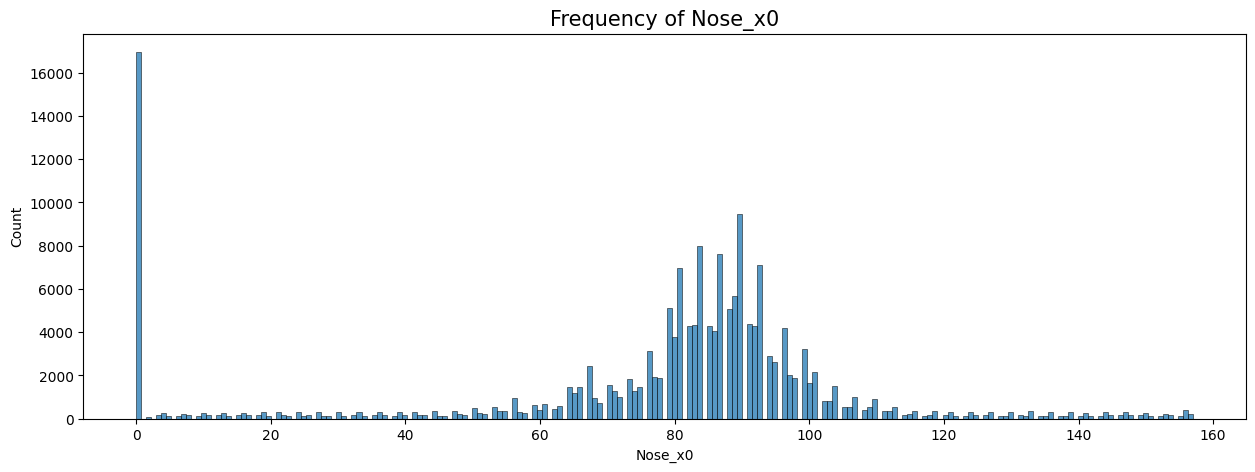

In [5]:
fig, ((axes1)) = plt.subplots(1,1, figsize=(15,5))
sns.histplot(data = df, x = 'Nose_x0', ax = axes1)
axes1.set_title('Frequency of Nose_x0', fontsize=15)
plt.show()

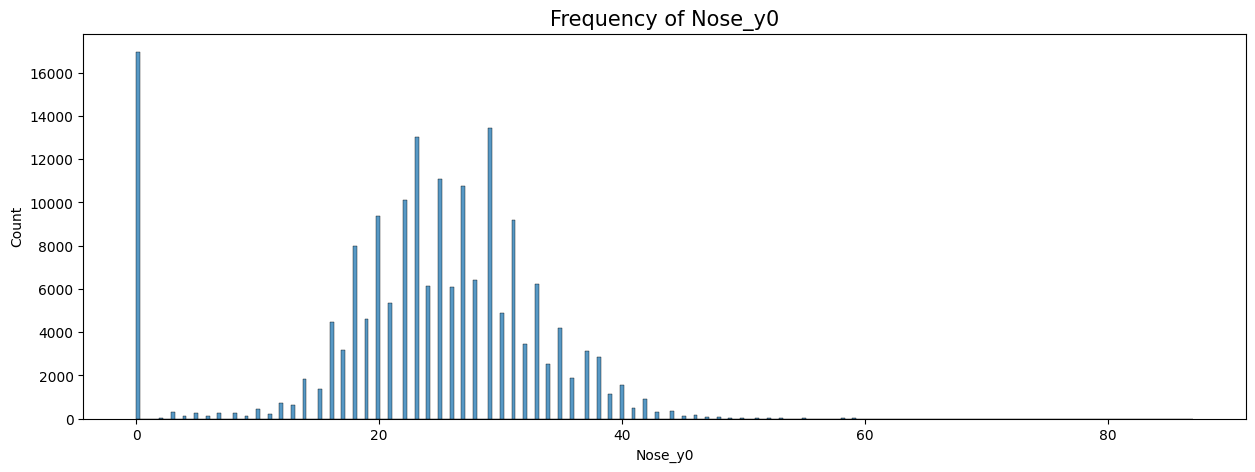

In [6]:
fig, ((axes1)) = plt.subplots(1,1, figsize=(15,5))
sns.histplot(data = df, x = 'Nose_y0', ax = axes1)
axes1.set_title('Frequency of Nose_y0', fontsize=15)
plt.show()

### Distribution of actions

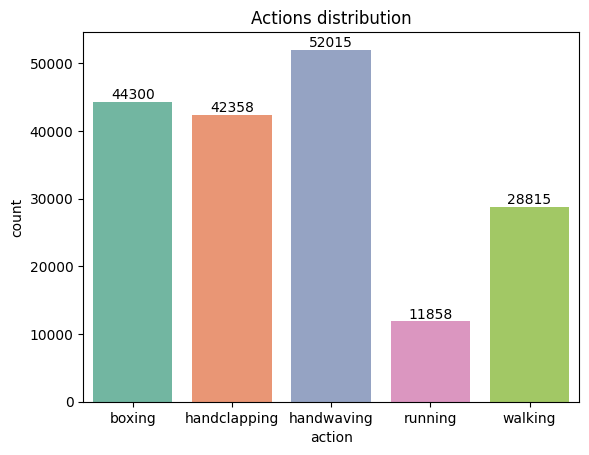

In [7]:
ax=sns.countplot(x ='action', data = df, palette = "Set2")
ax.bar_label(ax.containers[0])
plt.title('Actions distribution')
plt.show()

In [8]:
df.video_src.value_counts()

person17_handwaving_d2_uncomp.avi    824
person18_boxing_d3_uncomp.avi        782
person07_handwaving_d1_uncomp.avi    781
person07_handwaving_d4_uncomp.avi    777
person07_handwaving_d2_uncomp.avi    750
                                    ... 
person09_running_d1_uncomp.avi        36
person08_running_d1_uncomp.avi        36
person23_running_d3_uncomp.avi        31
person23_running_d1_uncomp.avi        27
person09_running_d3_uncomp.avi        16
Name: video_src, Length: 499, dtype: int64

In [9]:
# All values are unique that is why we can delete 'id' column
print('Unique values of id table: ', df.id.nunique())

# dropping 'video_src' since they don't have any relevant information
df = df.drop(['id', 'video_src'], axis = 1)
print(df.shape)

Unique values of id table:  179346
(179346, 37)


## LSTM - First model

### Briefly about LSTM

__LSTM__ stands for long short-term memory networks, used in the field of Deep Learning. <br>
It is a variety of recurrent neural networks (RNNs) that are capable of learning long-term dependencies, especially in sequence prediction problems. <br>
LSTM has __feedback connections__, i.e., it is capable of processing the entire sequence of data, apart from single data points such as images.

In [10]:
random_seed = 42   
n_time_steps = 50 
n_features = 3 
step = 10 
n_classes = 6 
n_epochs = 50       
batch_size = 1024   
learning_rate = 0.0025
l2_loss = 0.0015

In [11]:
from scipy import stats

In [12]:
df_train = df[df.index <= 107608]
df_test = df[df.index > 107608]

In [13]:
X = df.drop('action', axis=1)
y = df.action

In [14]:
from sklearn.preprocessing import RobustScaler

scale_columns = X.columns.values.tolist()
scaler = RobustScaler()
scaler = scaler.fit(df_train[scale_columns])

df_train.loc[:, scale_columns] = scaler.transform(
  df_train[scale_columns].to_numpy()
)

df_test.loc[:, scale_columns] = scaler.transform(
  df_test[scale_columns].to_numpy()
)

__Note:__ We fit the scaler only on the training data.

Using the modes of each category in the sequence, we select the label. That is, we categorize it as the category that happens most frequently given a sequence of length time steps.

In [15]:
def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

### Creating sequences

In [16]:
TIME_STEPS = 200
STEP = 40

X_train, y_train = create_dataset(
    df_train[X.columns.values.tolist()],
    df_train.action,
    TIME_STEPS,
    STEP
)

X_test, y_test = create_dataset(
    df_test[X.columns.values.tolist()],
    df_test.action,
    TIME_STEPS,
    STEP
)

Shape of new sequences.

In [17]:
print(X_train.shape, y_train.shape)

(2686, 200, 36) (2686, 1)


As we can see, we reduced the amount of train and test data.

### Encoding

In [18]:
from sklearn.preprocessing import OneHotEncoder

In [19]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc = enc.fit(y_train)
y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

### Model architecture

In [20]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(units=128,input_shape=[X_train.shape[1], X_train.shape[2]])))
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

Training is straightforward -> shuffle=False.

In [21]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/20
76/76 [==============================] - 24s 269ms/step - loss: 1.0682 - acc: 0.7737 - val_loss: 2.1314 - val_acc: 0.0000e+00
Epoch 2/20
76/76 [==============================] - 20s 259ms/step - loss: 0.7416 - acc: 0.7220 - val_loss: 1.6415 - val_acc: 0.2974
Epoch 3/20
76/76 [==============================] - 21s 279ms/step - loss: 0.3878 - acc: 0.8672 - val_loss: 1.3177 - val_acc: 0.4721
Epoch 4/20
76/76 [==============================] - 20s 261ms/step - loss: 0.2641 - acc: 0.9028 - val_loss: 1.1235 - val_acc: 0.5874
Epoch 5/20
76/76 [==============================] - 19s 257ms/step - loss: 0.1923 - acc: 0.9301 - val_loss: 0.9559 - val_acc: 0.6952
Epoch 6/20
76/76 [==============================] - 21s 273ms/step - loss: 0.1664 - acc: 0.9350 - val_loss: 1.0100 - val_acc: 0.6208
Epoch 7/20
76/76 [==============================] - 20s 262ms/step - loss: 0.1241 - acc: 0.9561 - val_loss: 0.7710 - val_acc: 0.7063
Epoch 8/20
76/76 [==============================] - 20s 266ms/ste

In [22]:
loss, accuracy = model.evaluate(X_test, y_test, batch_size = batch_size, verbose = 1)
print("Accuracy :", accuracy)
print("Loss :", loss)

2/2 [==============================] - 1s 539ms/step - loss: 0.2255 - acc: 0.9206
Accuracy : 0.9206260442733765
Loss : 0.22549475729465485


__Result:__ Accuracy: 92.1% with a loss of 0.23. 

### Confusion matrix

56/56 [==============================] - 5s 80ms/step


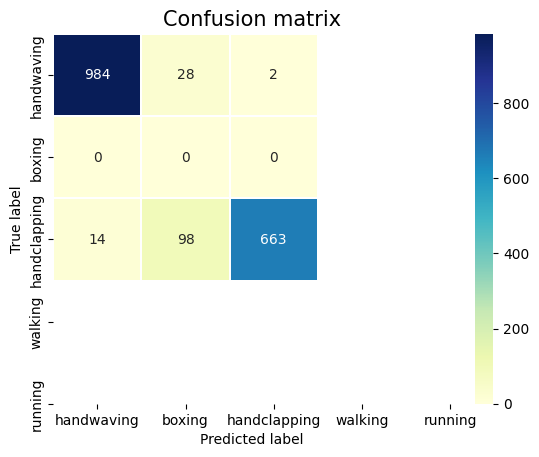

In [23]:
import sklearn.metrics as metrics

predictions = model.predict(X_test)
class_labels = ['handwaving', 'boxing', 'handclapping', 'walking', 'running']
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
sns.heatmap(confusion_matrix, xticklabels = class_labels, yticklabels = class_labels, annot = True, linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## LSTM - Second model

### Encoding

In [24]:
from sklearn import preprocessing
  
label_encoder = preprocessing.LabelEncoder()
df['action']= label_encoder.fit_transform(df['action'])
df['action'].unique()

array([0, 1, 2, 3, 4])

5 unique values of action, are now encoded as 0-4.

In [25]:
random_seed = 42   
n_time_steps = 50 
n_features = 36 
step = 10 
n_classes = 6 
n_epochs = 50       
batch_size = 1024   
learning_rate = 0.0025
l2_loss = 0.0015

### Generating sequence containing 50 records, since n_steps=50.

In [26]:
step = 10
n_steps = 50
segments = []
labels = []
coords = df.columns[:-1]

for i in range(0,  df.shape[0] - n_steps, step):  
    d = {}
    for coord in coords:
        d[f'{coord}'] = df[f'{coord}'].values[i: i + n_steps]

    label = stats.mode(df['action'][i: i + n_steps])[0][0]
    segments.append(list(d.values()))
    
    labels.append(label)

Reshape the segments which is (list of arrays) to a list.

In [27]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, n_time_steps, n_features)

labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [28]:
reshaped_segments.shape

(17930, 50, 36)

### Train and test split

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size = 0.2, random_state = random_seed)

### Model architecture

In [31]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Dropout

In [32]:
model = Sequential()
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5)) 
model.add(Dense(units = 64, activation='relu'))
model.add(Dense(5, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               84480     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 5)                 325       
                                                                 
Total params: 93,061
Trainable params: 93,061
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = model.fit(X_train, y_train, epochs = n_epochs, batch_size = batch_size, verbose = 1)

Epoch 1/50
15/15 [==============================] - 6s 246ms/step - loss: 1.2804 - accuracy: 0.4395
Epoch 2/50
15/15 [==============================] - 4s 246ms/step - loss: 0.9763 - accuracy: 0.5892
Epoch 3/50
15/15 [==============================] - 3s 221ms/step - loss: 0.8048 - accuracy: 0.6585
Epoch 4/50
15/15 [==============================] - 3s 221ms/step - loss: 0.7127 - accuracy: 0.6912
Epoch 5/50
15/15 [==============================] - 3s 225ms/step - loss: 0.6630 - accuracy: 0.7204
Epoch 6/50
15/15 [==============================] - 4s 249ms/step - loss: 0.5906 - accuracy: 0.7538
Epoch 7/50
15/15 [==============================] - 3s 230ms/step - loss: 0.5555 - accuracy: 0.7709
Epoch 8/50
15/15 [==============================] - 3s 215ms/step - loss: 0.5270 - accuracy: 0.7796
Epoch 9/50
15/15 [==============================] - 3s 220ms/step - loss: 0.5272 - accuracy: 0.7867
Epoch 10/50
15/15 [==============================] - 3s 231ms/step - loss: 0.5264 - accuracy: 0.7786

In [35]:
loss, accuracy = model.evaluate(X_test, y_test, batch_size = batch_size, verbose = 1)
print("Accuracy :", accuracy)
print("Loss :", loss)

4/4 [==============================] - 1s 56ms/step - loss: 0.3554 - accuracy: 0.8634
Accuracy : 0.8633574843406677
Loss : 0.3554420471191406


__Result:__ We have got an accuracy of 86% with a loss of 0.355.

### Confusion matrix

113/113 [==============================] - 3s 14ms/step


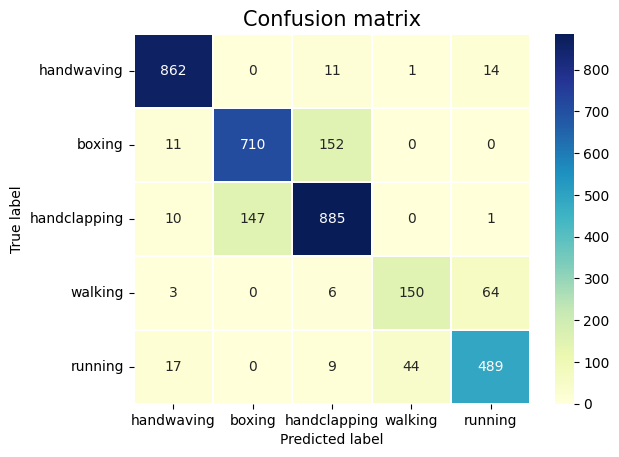

In [36]:
predictions = model.predict(X_test)
class_labels = ['handwaving', 'boxing', 'handclapping', 'walking', 'running']
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
sns.heatmap(confusion_matrix, xticklabels = class_labels, yticklabels = class_labels, annot = True, linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Pros:

- LSTMs can effectively handle sequential data and long-term dependencies, making them suitable for tasks such as language modeling, speech recognition, and time series prediction.
- LSTMs have a special type of memory cell that can retain information for long periods of time, which allows them to effectively process sequences of data.
- LSTMs can handle variable-length sequences, which makes them more flexible than other types of RNNs.
- LSTMs can be used for unsupervised learning, for example in autoencoders or variational autoencoder (VAE)

Cons:

- LSTMs can be computationally expensive to train and use, due to their complex architecture and the need to process sequential data.
- LSTMs can be difficult to interpret and understand, making it harder to debug and improve the model.
- LSTMs can be prone to overfitting, especially when the dataset is small or the model is not properly regularized.
- LSTMs are not easily parallelizable, this means that the training process is slower than other types of neural networks.

In summary, LSTMs are a powerful tool for tasks involving sequential data and long-term dependencies, but they can be computationally expensive and difficult to interpret. It's important to carefully consider the task and available resources before deciding to use an LSTM.

## Feedforward Neural Network (FFNN)

FFNN (Feedforward Neural Network) are well-suited for tasks that do not involve sequential data and long-term dependencies

Pros:

- FFNNs can be used for a wide range of tasks, such as image classification, object detection, and recommender systems.
- FFNNs are relatively simple to train and use, compared to other types of neural networks, such as recurrent neural networks (RNNs) or convolutional neural networks (CNNs).
- FFNNs can be easily parallelizable, which means that the training process can be faster than other types of neural networks.
- FFNNs are easily interpretable, this means that it's easy to understand how the model is making predictions.

Cons:

- FFNNs are not well-suited for tasks involving sequential data or long-term dependencies, as they do not have an inherent mechanism for preserving information over time.
- FFNNs can be prone to overfitting, especially when the dataset is small or the model is not properly regularized.
- FFNNs may not be as accurate as other types of neural networks, such as CNNs, for certain tasks, such as image classification or object detection.
- FFNNs may require more data to train, to avoid overfitting or underfitting.

In [37]:
X = df.drop('action', axis=1)
y = df.action

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_seed)

### Model architecture

In [39]:
from keras.layers import Dense
from keras.models import Sequential
 
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(36,)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               18944     
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                 2565      
                                                                 
 dense_6 (Dense)             (None, 1)                 6         
                                                                 
Total params: 21,515
Trainable params: 21,515
Non-trainable params: 0
_________________________________________________________________


In [40]:
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=25)

Epoch 1/20
5740/5740 [==============================] - 12s 2ms/step - loss: 0.0000e+00 - accuracy: 0.2360 - val_loss: 0.0000e+00 - val_accuracy: 0.2370
Epoch 2/20
5740/5740 [==============================] - 12s 2ms/step - loss: 0.0000e+00 - accuracy: 0.2360 - val_loss: 0.0000e+00 - val_accuracy: 0.2370
Epoch 3/20
5740/5740 [==============================] - 12s 2ms/step - loss: 0.0000e+00 - accuracy: 0.2360 - val_loss: 0.0000e+00 - val_accuracy: 0.2370
Epoch 4/20
5740/5740 [==============================] - 12s 2ms/step - loss: 0.0000e+00 - accuracy: 0.2360 - val_loss: 0.0000e+00 - val_accuracy: 0.2370
Epoch 5/20
5740/5740 [==============================] - 11s 2ms/step - loss: 0.0000e+00 - accuracy: 0.2360 - val_loss: 0.0000e+00 - val_accuracy: 0.2370
Epoch 6/20
5740/5740 [==============================] - 11s 2ms/step - loss: 0.0000e+00 - accuracy: 0.2360 - val_loss: 0.0000e+00 - val_accuracy: 0.2370
Epoch 7/20
5740/5740 [==============================] - 11s 2ms/step - loss: 0.000

In [41]:
loss, accuracy = model.evaluate(X_test, y_test, batch_size = 25, verbose = 1)
print("Test Accuracy :", accuracy)
print("Test Loss :", loss)

1435/1435 [==============================] - 2s 1ms/step - loss: 0.0000e+00 - accuracy: 0.2370
Test Accuracy : 0.23702257871627808
Test Loss : 0.0


__Results:__ So in this example we have got an accuracy of 24%.

### Confusion matrix

1121/1121 [==============================] - 1s 912us/step


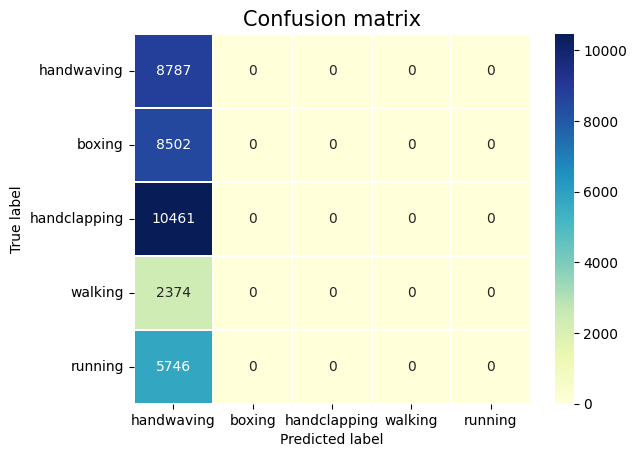

In [42]:
predictions = model.predict(X_test)
class_labels = ['handwaving', 'boxing', 'handclapping', 'walking', 'running']
max_test = y_test.astype(int).tolist()
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
sns.heatmap(confusion_matrix, xticklabels = class_labels, yticklabels = class_labels, annot = True, linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

As we can see from the confusion matrix above, this model predicts every action as handwaving, which is not right. Since there are 5 different actions, that is why we have such a low accuracy.

## Conclusion

LSTM (Long Short-Term Memory) and FFNN (Feedforward Neural Network) are both types of neural networks, but they are used for different tasks and have different architectures.

#### LSTM
An LSTM network is a type of recurrent neural network (RNN) that is designed to handle sequential data. 
It is particularly useful for tasks that involve long-term dependencies, such as speech recognition, language translation, and time series prediction. LSTMs have a special type of memory cell that can retain information for long periods of time, allowing them to effectively process sequences of data.

In our case it is better to use LSTM with __Video analysis__: LSTMs can be used to analyze video data, for example, to predict the next frame in a video or to detect objects or actions in the video.

#### FFNN
A FFNN, on the other hand, is a type of feedforward neural network that is used for tasks that do not involve sequential data. It consists of layers of interconnected nodes (neurons) that process the input data and produce an output. FFNNs are commonly used for image classification, object detection, and other tasks that involve analyzing static data.

__Comparison:__
- LSTMs are designed to let important information persist over time. RNNs will often "forget" over time.
- FFNNs are memoryless systems; after processing some input, they forget everything about that input.
- Since LSTM is biderctional and FFNN is straightforward only, LSTM has much higher complexity.

#### Results
For LSTM I have created 2 models. In the first one I used RobustScaler for train data. In both of the models, sequences of 50 steps are used. First model showed better result with accuracy 92%, while second one was 86%.
However, when I used FFNN my accuracy was 24%. And according to the confusion matrix, model was predicting every action as handwaving.